In [9]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install toolz

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install netcdf4

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install h5netcdf 

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install cfgrib

Note: you may need to restart the kernel to use updated packages.


In [16]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

### **<font color="Purple"> Datos de ERA5 </font>**

### **<font color="olive"> Viento</font>**

In [17]:
fileu_era5 = 'datasetsok/u_daily_500_200_1979-2024.nc'

In [18]:
u_ds = xr.open_dataset(fileu_era5)
u_era5 = u_ds['u']

In [49]:
#Seleccionar solo 200 hPa 
u200E5 = u_era5.sel(pressure_level=200)

##### **<font color="olive"> Geopotencial </font>**

##### **<font color="olive"> Concat de índice >1 y valores de gph </font>**

In [20]:
# esta es la base que tiene solo las fechas cuando el índice > 1
# es también las anomalías del ciclo anual de gph

In [50]:
idxp_gph_file = 'datasetsok/gph_idx_std+.nc'

In [51]:
idxp_gph_ds = xr.open_dataset(idxp_gph_file)
idxp_gph = idxp_gph_ds['z']
idxp_gph = idxp_gph.sel(pressure_level=500)
idxp_gph['time'] = idxp_gph.time.dt.floor("D")

##### **<font color="olive"> Concat de índice <-1 y valores de gph </font>**

In [52]:
idxn_gph_file = 'datasetsok/gph_idx_std-.nc'

In [53]:
idxn_gph_ds = xr.open_dataset(idxn_gph_file)
idxn_gph = idxn_gph_ds['z']
idxn_gph = idxn_gph.sel(pressure_level=500)

In [54]:
idxn_gph_vals = idxn_gph.mean(dim='time')
idxn_gph_seasons = idxn_gph.groupby(idxn_gph.time.dt.season).mean(dim='time') #DJF
idxn_gph_djf = idxn_gph_seasons[0]

##### **<font color="olive"> Promedio de área </font>**

In [73]:
#Elegir un cuadro de 4x4
latitudes = u200E5.sel(latitude=slice(27,22))
longitudes = latitudes.sel(longitude=slice(255,262))

In [75]:
weights = np.cos(np.deg2rad(latitudes.latitude))
weights.name = "weights"

In [76]:
u200E5_weighted = longitudes.weighted(weights)

In [77]:
promareaE5 = u200E5_weighted.mean(['longitude','latitude']) 

In [79]:
#desestacionalizar el promedio de área 

In [80]:
u200E5_climday = promareaE5.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

In [81]:
u200E5climdaysuav = u200E5_climday.rolling(dayofyear=7, center=True, min_periods=1).mean()

In [82]:
anomaliasdayE5 = promareaE5.groupby('time.dayofyear') - u200E5climdaysuav 

##### **<font color="olive"> Temperatura e índice >1 (con valores de gph) </font>**

In [84]:
missing_times_T = np.setdiff1d(idxp_gph.time.values, anomaliasdayE5.time.values)
# print(missing_times_T)
len(missing_times_T)

0

In [85]:
t2m_ds_idxp = anomaliasdayE5.reindex(time=idxp_gph.time) #del campo de temperatura solo agarró las fechas cuando índice es positivo

##### **<font color="olive"> Temperatura e índice <-1 (con valores de gph) </font>**

In [86]:
missing_times_Tn = np.setdiff1d(idxn_gph.time.values, anomaliasdayE5.time.values)
# print(missing_times_Tn)
len(missing_times_Tn)

0

In [87]:
t2m_ds_idxn = anomaliasdayE5.reindex(time=idxn_gph.time)  #del campo de temperatura solo agarró las fechas cuando índice es negativo

In [88]:
t2m_pos_mean = t2m_ds_idxp.to_series()
t2m_neg_mean = t2m_ds_idxn.to_series()

df = pd.DataFrame({
    "Anomalía": pd.concat([t2m_pos_mean, t2m_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(t2m_pos_mean) +
        ["PNA negativo"] * len(t2m_neg_mean)
    )
})

In [89]:
df

,Anomalía,Fase
time,,
1979-03-03,12.824937,PNA positivo
1979-03-04,15.351547,PNA positivo
1979-03-05,23.211779,PNA positivo
1979-03-06,24.185615,PNA positivo
1979-03-07,11.690088,PNA positivo
...,...,...
2022-12-09,-17.384689,PNA negativo
2022-12-10,-10.639030,PNA negativo
2022-12-11,-3.229752,PNA negativo


/tmp/ipykernel_1240/3331940412.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Fase", y="Anomalía", palette="coolwarm")


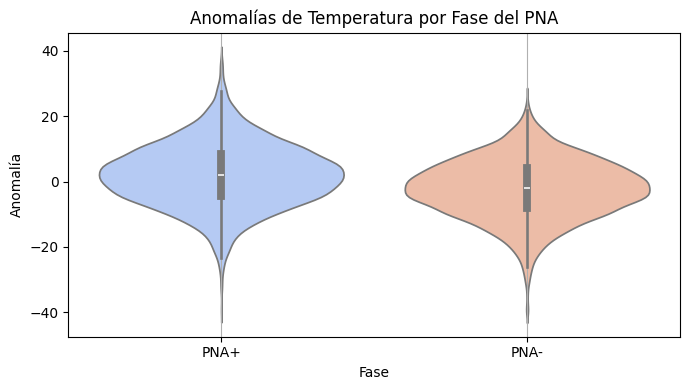

In [90]:
t2m_pos_mean = t2m_ds_idxp.to_series()
t2m_neg_mean = t2m_ds_idxn.to_series()

df = pd.DataFrame({
    "Anomalía": pd.concat([t2m_pos_mean, t2m_neg_mean]),
    "Fase": (
        ["PNA+"] * len(t2m_pos_mean) +
        ["PNA-"] * len(t2m_neg_mean)
    )
})

plt.figure(figsize=(7, 4))
sns.violinplot(data=df, x="Fase", y="Anomalía", palette="coolwarm")
plt.title("Anomalías de Temperatura por Fase del PNA")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


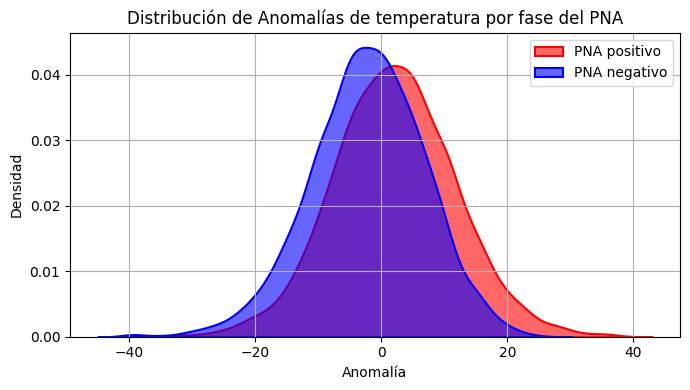

In [91]:
# Separar los datos por fase
pos_data = df[df["Fase"] == "PNA+"]["Anomalía"]
neg_data = df[df["Fase"] == "PNA-"]["Anomalía"]

plt.figure(figsize=(7, 4))
sns.kdeplot(pos_data, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6)
sns.kdeplot(neg_data, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6)

plt.title("Distribución de Anomalías de temperatura por fase del PNA")
plt.xlabel("Anomalía")
plt.ylabel("Densidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### **<font color="Purple"> Datos de HadGEM3</font>**

### **<font color="olive"> Viento </font>**

In [95]:
file_uHG = 'datasetsok/uday_250hpa_HG_1979_2014.nc'

In [109]:
uHGds = xr.open_dataset(file_uHG)
uHG = uHGds['ua']

##### **<font color="olive"> Promedio de área </font>**

In [110]:
#Elegir un cuadro de 4x4
latitudes = uHG.sel(lat=slice(22,27))
longitudes = latitudes.sel(lon=slice(255,262))

In [111]:
weights = np.cos(np.deg2rad(latitudes.lat))
weights.name = "weights"

In [112]:
uHG_weighted = longitudes.weighted(weights)

In [113]:
promareaHG = uHG_weighted.mean(['lon','lat']) 

In [114]:
#desestacionalizar promedio de área

In [115]:
uHG_climday = promareaHG.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

In [116]:
uHGclimdaysuav = uHG_climday.rolling(dayofyear=7, center=True, min_periods=1).mean()

In [117]:
anomaliasdayHG = promareaHG.groupby('time.dayofyear') - uHGclimdaysuav 

In [120]:
anomaliasdayHG['time'] = anomaliasdayHG.time.dt.floor("D")

##### **<font color="olive"> Geopotencial </font>**

##### **<font color="olive"> Concat de índice >1 y valores de gph </font>**

In [121]:
idxp_zg_file = 'datasetsok/zg500_idx_std+.nc'
idxp_zg_ds = xr.open_dataset(idxp_zg_file)
idxp_zg = idxp_zg_ds['zg500']
idxp_zg['time'] = idxp_zg.time.dt.floor("D")

##### **<font color="olive"> Temperatura e índice >1 (con valores de gph) </font>**

In [122]:
missing_times = np.setdiff1d(idxp_zg.time.values, anomaliasdayHG.time.values)
# print(missing_times)
len(missing_times)

0

##### **<font color="olive"> Concat de índice <-1 y valores de gph </font>**

In [123]:
idxn_zg_file = 'datasetsok/zg500_idx_std-.nc'
idxn_zg_ds = xr.open_dataset(idxn_zg_file)
idxn_zg = idxn_zg_ds['zg500']
idxp_zg['time'] = idxp_zg.time.dt.floor("D")

##### **<font color="olive"> Temperatura e índice <-1 (con valores de gph) </font>**

In [125]:
missing_times = np.setdiff1d(idxn_zg.time.values, anomaliasdayHG.time.values)
# print(missing_times)
len(missing_times)

0

In [130]:
uHG_idxp=anomaliasdayHG.sel(time=idxp_zg.time.values)

In [131]:
uHG_idxn=anomaliasdayHG.sel(time=idxn_zg.time.values)

In [132]:
uHG_pos_mean = tas_idxp.to_series()
uHG_neg_mean = tas_idxn.to_series()

dfHG = pd.DataFrame({
    "Anomalía": pd.concat([uHG_pos_mean, uHG_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(uHG_pos_mean) +
        ["PNA negativo"] * len(uHG_neg_mean)
    )
})

/tmp/ipykernel_1240/517824676.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm")


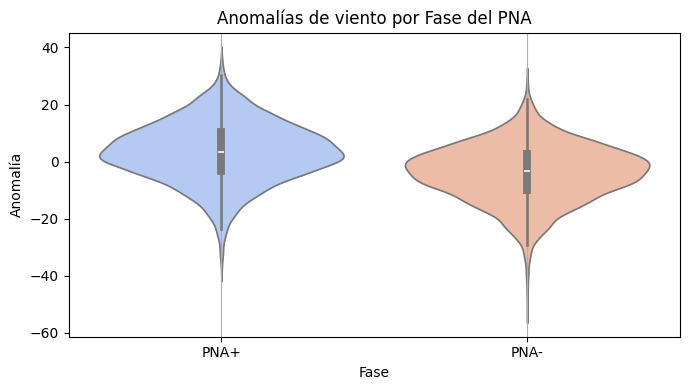

In [134]:
uHG_pos_mean = uHG_idxp.to_series()
uHG_neg_mean = uHG_idxn.to_series()

dfHG = pd.DataFrame({
    "Anomalía": pd.concat([uHG_pos_mean, uHG_neg_mean]),
    "Fase": (
        ["PNA+"] * len(uHG_pos_mean) +
        ["PNA-"] * len(uHG_neg_mean)
    )
})

plt.figure(figsize=(7, 4))
sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm")
plt.title("Anomalías de viento por Fase del PNA")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


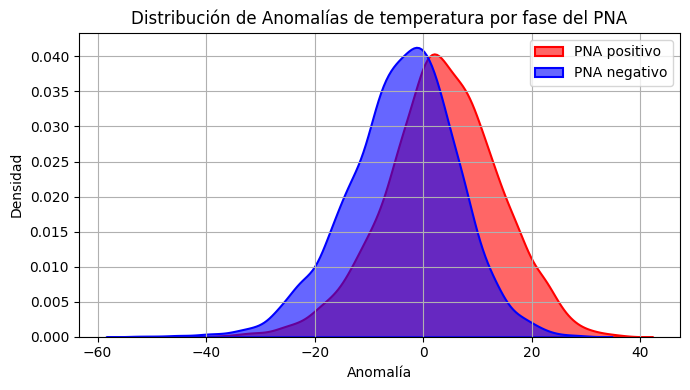

In [135]:
# Separar los datos por fase
pos_data = dfHG[dfHG["Fase"] == "PNA+"]["Anomalía"]
neg_data = dfHG[dfHG["Fase"] == "PNA-"]["Anomalía"]

plt.figure(figsize=(7, 4))
sns.kdeplot(pos_data, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6)
sns.kdeplot(neg_data, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6)

plt.title("Distribución de Anomalías de temperatura por fase del PNA")
plt.xlabel("Anomalía")
plt.ylabel("Densidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1240/2827188301.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[0])
/tmp/ipykernel_1240/2827188301.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfT2M, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[1])


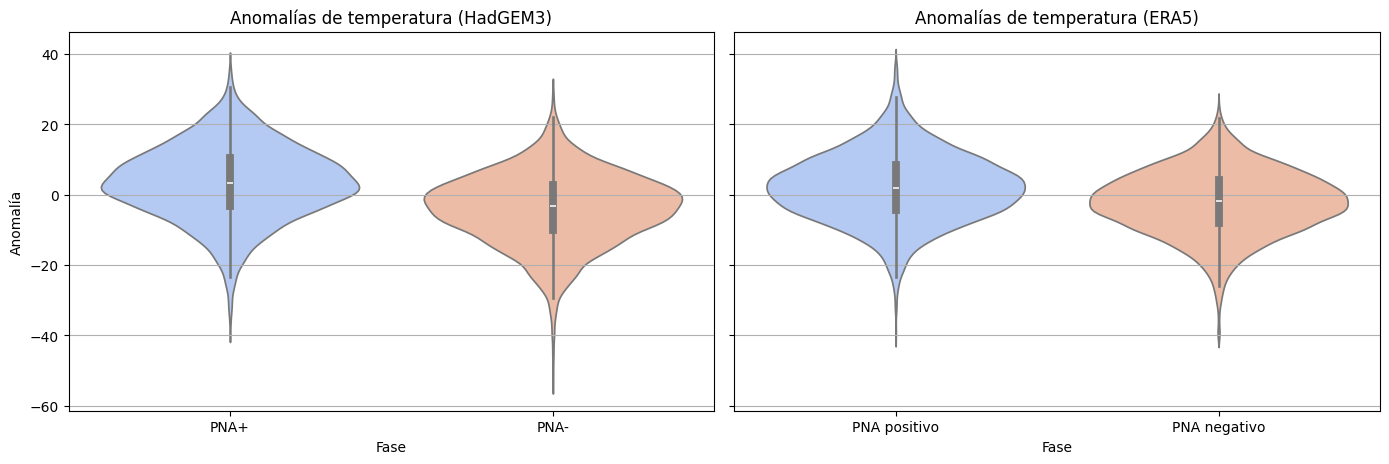

In [138]:
tas_pos_mean = tas_idxp.to_series()
tas_neg_mean = tas_idxn.to_series()

dfHG = pd.DataFrame({
    "Anomalía": pd.concat([tas_pos_mean, tas_neg_mean]),
    "Fase": (
        ["PNA+"] * len(tas_pos_mean) +
        ["PNA-"] * len(tas_neg_mean)
    )
})


t2m_pos_mean = t2m_ds_idxp.to_series()
t2m_neg_mean = t2m_ds_idxn.to_series()

dfT2M = pd.DataFrame({
    "Anomalía": pd.concat([t2m_pos_mean, t2m_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(t2m_pos_mean) +
        ["PNA negativo"] * len(t2m_neg_mean)
    )
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: tas
sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[0])
axes[0].set_title("Anomalías de temperatura (HadGEM3)")
axes[0].grid(True, axis='y')

# Plot 2: t2m
sns.violinplot(data=dfT2M, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[1])
axes[1].set_title("Anomalías de temperatura (ERA5)")
axes[1].grid(True, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


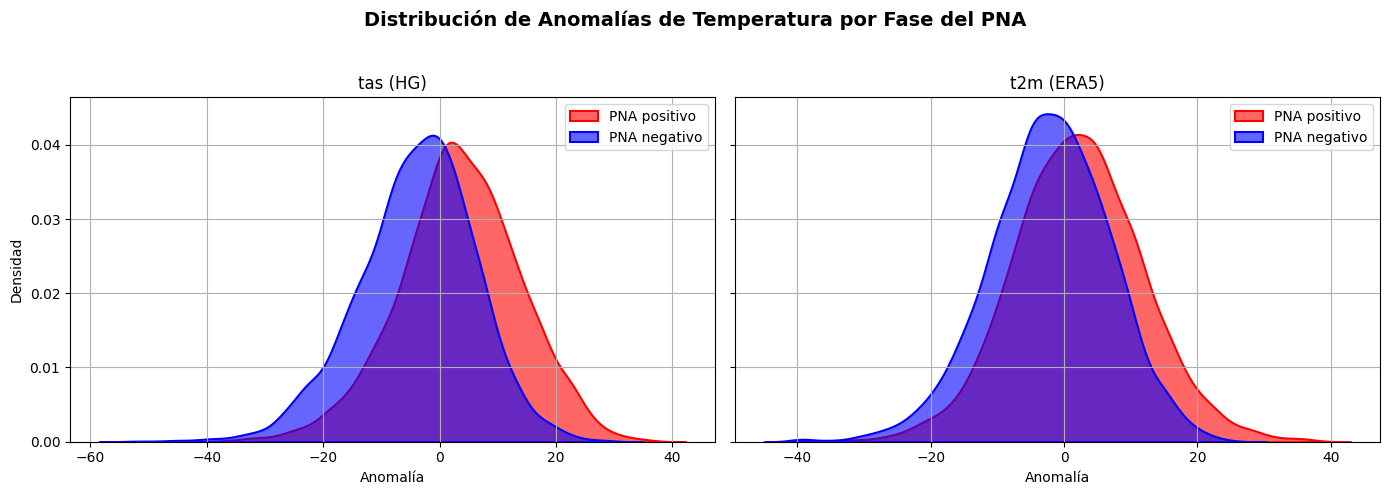

In [139]:
# Separar datos por fase para dfHG (tas)
pos_hg = dfHG[dfHG["Fase"] == "PNA+"]["Anomalía"]
neg_hg = dfHG[dfHG["Fase"] == "PNA-"]["Anomalía"]

# Separar datos por fase para df (t2m)
pos_t2m = df[df["Fase"] == "PNA+"]["Anomalía"]
neg_t2m = df[df["Fase"] == "PNA-"]["Anomalía"]

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# KDE plot para tas (HG)
sns.kdeplot(pos_hg, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6, ax=axes[0])
sns.kdeplot(neg_hg, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6, ax=axes[0])
axes[0].set_title("tas (HG)")
axes[0].set_xlabel("Anomalía")
axes[0].set_ylabel("Densidad")
axes[0].grid(True)
axes[0].legend()

# KDE plot para t2m
sns.kdeplot(pos_t2m, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6, ax=axes[1])
sns.kdeplot(neg_t2m, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6, ax=axes[1])
axes[1].set_title("t2m (ERA5)")
axes[1].set_xlabel("Anomalía")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend()

# Título general
fig.suptitle("Distribución de Anomalías de viento por Fase del PNA", fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
